# XGBoost feature selection, including time left to thrombolyse and removal of onset-to-arrival and arrival-to-scan

## Aims

* Include 'time left to thrombolyse after scan' in features. This is equal to *270 - (onset-to-arrival + arrival-to-scan)*. Then remove onset-to-arrival and arrival-to-scan.
* Select up to 10 features using forward feature selection. Features are selected sequentially, choosing the feature that leads to most improvement in ROC AUC score.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

## Create output folder if needed

In [2]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [3]:
data_loc = '../data/kfold_5fold/'

In [4]:
train_data, test_data = [], []

for i in range(5):
    
    train_data.append(pd.read_csv(data_loc + 'train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(data_loc + 'test_{0}.csv'.format(i)))

## Add time left to thrombolyse after scan & remove arrival and scan times

In [5]:
for i in range(5):
    
    cols_to_drop = ['S1OnsetToArrival_min', 'S2BrainImagingTime_min']
    
    train_data[i]['time_left_after_scan'] = (
        270 - (train_data[i]['S1OnsetToArrival_min'] + 
               train_data[i]['S2BrainImagingTime_min']))
    
    train_data[i].drop(cols_to_drop, axis=1, inplace=True)    
    
    test_data[i]['time_left_after_scan'] = (
        270 - (test_data[i]['S1OnsetToArrival_min'] + 
               test_data[i]['S2BrainImagingTime_min']))
    
    test_data[i].drop(cols_to_drop, axis=1, inplace=True) 

## Get list of features

In [6]:
features = list(train_data[0])

## Fit model (k-fold)

In [7]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
roc_auc_k_fold_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(train_data[0].drop('S2Thrombolysis', axis=1))
number_of_features = len(available_features)

# Loop through number of features

for i in range (10):
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''
    
    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        
        # Set up lists to hold AUC results for each selected feature under test
        test_auc_results = []
        
        # Loop through k folds
        for k_fold in range(5):

            # Get k fold split
            train = train_data[k_fold]
            test = test_data[k_fold]

            # Get X and y
            X_train = train.drop('S2Thrombolysis', axis=1)
            X_test = test.drop('S2Thrombolysis', axis=1)
            y_train = train['S2Thrombolysis']
            y_test = test['S2Thrombolysis']
            
            # Restrict features
            X_train = X_train[features_to_use]
            X_test = X_test[features_to_use]
    
            # One hot encode hospitals if hospital in features used
            if 'StrokeTeam' in features_to_use:
                X_train_hosp = pd.get_dummies(
                    X_train['StrokeTeam'], prefix = 'team')
                X_train = pd.concat([X_train, X_train_hosp], axis=1)
                X_train.drop('StrokeTeam', axis=1, inplace=True)
                X_test_hosp = pd.get_dummies(
                    X_test['StrokeTeam'], prefix = 'team')
                X_test = pd.concat([X_test, X_test_hosp], axis=1)
                X_test.drop('StrokeTeam', axis=1, inplace=True)    

            # Define model
            model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

            # Fit model
            model.fit(X_train, y_train)

            # Get predicted probabilities
            y_probs = model.predict_proba(X_test)[:,1]
            
            # Get ROC AUC
            fpr, tpr, thresholds = roc_curve(y_test, y_probs)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc > best_result:
            best_result = feature_auc
            best_result_k_fold = test_auc_results
            best_feature = feature
            
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    roc_auc_k_fold_by_feature_number.append(best_result_k_fold)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)
            
    print (f'Feature {i+1:2.0f}: {best_feature}, AUC: {best_result:0.3f}')

Feature  1: time_left_after_scan, AUC: 0.708
Feature  2: S2StrokeType_Infarction, AUC: 0.787
Feature  3: S2NihssArrival, AUC: 0.848
Feature  4: S2RankinBeforeStroke, AUC: 0.871
Feature  5: S1OnsetTimeType_Best estimate, AUC: 0.887
Feature  6: StrokeTeam, AUC: 0.900
Feature  7: AFAnticoagulent_Yes, AUC: 0.911
Feature  8: S1OnsetDateType_Stroke during sleep, AUC: 0.913
Feature  9: BestLanguage, AUC: 0.914
Feature 10: AFAnticoagulentVitK_missing, AUC: 0.915


In [8]:
results = pd.DataFrame()
results['number_features'] = range(1, len(chosen_features)+1)
results['feature'] = chosen_features
results['AUC'] = roc_auc_by_feature_number
results['AUC_Std'] = [np.std(auc) for auc in roc_auc_k_fold_by_feature_number]
results

,number_features,feature,AUC,AUC_Std
0,1,time_left_after_scan,0.708390,0.003263
1,2,S2StrokeType_Infarction,0.787110,0.004032
2,3,S2NihssArrival,0.847513,0.002918
3,4,S2RankinBeforeStroke,0.870545,0.002090
4,5,S1OnsetTimeType_Best estimate,0.886981,0.001939
5,6,StrokeTeam,0.899754,0.002208
6,7,AFAnticoagulent_Yes,0.911309,0.002020
7,8,S1OnsetDateType_Stroke during sleep,0.913395,0.001913
8,9,BestLanguage,0.914444,0.001836
9,10,AFAnticoagulentVitK_missing,0.915102,0.001837


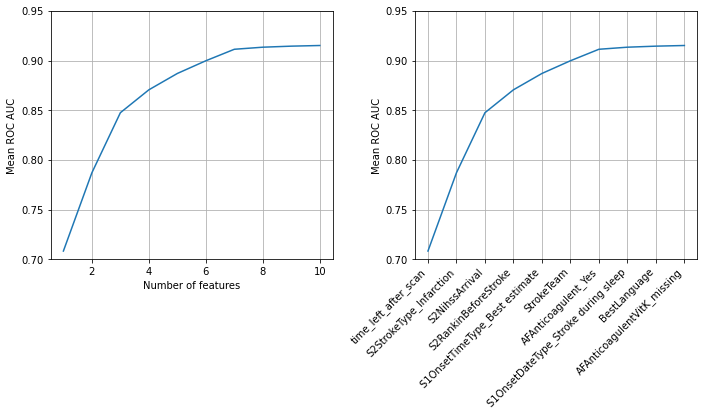

In [9]:
features_to_show = 10

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121)
ax1.plot(results['number_features'], results['AUC'])
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Mean ROC AUC')
ax1.set_ylim(0.7, 0.95)
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(results['feature'][:features_to_show],
         results['AUC'][:features_to_show])
xlabels = list(results['feature'])
xlabels = xlabels[:features_to_show]
ax2.set_xticklabels(xlabels, rotation=45, ha='right')
ax2.set_ylabel('Mean ROC AUC')
ax2.set_ylim(0.7, 0.95)
ax2.grid()

plt.tight_layout(pad=1.5)
plt.savefig(f'./output/feature_selection.jpg', dpi=300)
plt.show()

In [10]:
results.to_csv('./output/feature_selection_3.csv', index=False)

## Observations

* After removal of onset-to-arrival and arrival-to-scan, time_left_after_scan was the first selected feature.
* time_left_after_scan alone produced an ROC AUC of 0.708, compared with 0.715 for arrival-to-scan (when available)